In [1]:
import os
from tqdm import tqdm
import time
import pickle
import getpass
import pandas as pd
import numpy as np
from scipy import stats
import jax
import jax.numpy as jnp
from jax import jit, grad, random

import optax

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set()
from IPython.display import set_matplotlib_formats

set_matplotlib_formats("pdf", "png")
# plt.tight_layout()
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.titlesize"] = 28
plt.rcParams["font.size"] = 28
plt.rcParams["lines.linewidth"] = 1.5
plt.rcParams["lines.markersize"] = 7
plt.rcParams["grid.linestyle"] = "--"
plt.rcParams["grid.linewidth"] = 1.0
plt.rcParams["legend.fontsize"] = 16
plt.rcParams["legend.facecolor"] = "white"
plt.rcParams["axes.labelsize"] = 28
plt.rcParams["xtick.labelsize"] = 28
plt.rcParams["ytick.labelsize"] = 28
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8
plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

%env XLA_PYTHON_CLIENT_ALLOCATOR=platform
eps = 1e-6



env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


<ipython-input-1-51bc72a861ac>:46: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']


In [2]:
import pickle
with open('./function-space-variational-inference/fsvi_cl/baselines/vcl/results/original_data/10pmnist_fixed', 'rb') as pickle_file:
    vcl = pickle.load(pickle_file)

vcl_acc_mean = []
for i in range(vcl['rand_vcl_result'].shape[0]):
    vcl_acc_mean.append(vcl['rand_vcl_result'][i,:(i+1)].mean())
     

dataset_pmnist__method_ntk_norm__reg_30000.0__seed_3__2__complete
dataset_pmnist__method_ntk_norm__reg_30000.0__seed_1__2__complete
dataset_pmnist__method_ntk_norm__reg_30000.0__seed_2__2__complete
dataset_pmnist__method_ntk_norm__reg_30000.0__seed_0__2__complete
dataset_pmnist__method_ntk_norm__reg_30000.0__seed_4__2__complete
dataset_pmnist__method_weight_l2_without_fisher__reg_0.001__seed_1__1__complete
dataset_pmnist__method_weight_l2_without_fisher__reg_0.001__seed_0__1__complete
dataset_pmnist__method_weight_l2_without_fisher__reg_0.001__seed_4__1__complete
dataset_pmnist__method_weight_l2_without_fisher__reg_0.001__seed_3__1__complete
dataset_pmnist__method_weight_l2_without_fisher__reg_0.001__seed_2__1__complete
dataset_pmnist__method_function_l2__reg_0.01__seed_4__2__complete
dataset_pmnist__method_function_l2__reg_0.01__seed_1__2__complete
dataset_pmnist__method_function_l2__reg_0.01__seed_3__2__complete
dataset_pmnist__method_function_l2__reg_0.01__seed_0__1__complete
datase

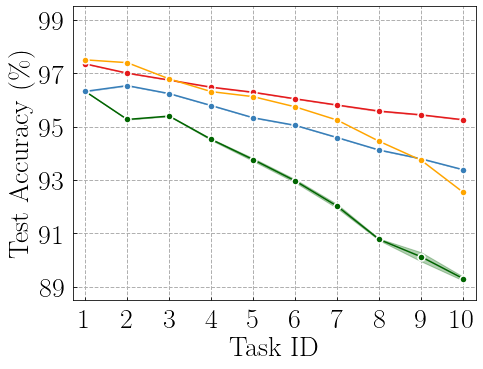

In [4]:
fig = plt.figure(figsize=(8, 6))
ax_test_acc = fig.subplots(1, 1)


dataset = 'pmnist'
method_list = ['ntk_norm', 'weight_l2_without_fisher', 'function_l2']

cmap = plt.get_cmap("tab20c")
blue = plt.get_cmap("Set1")(1)
red = plt.get_cmap("Set1")(0)
cmap_2 = plt.get_cmap("tab10")
cmap_3 = plt.get_cmap("Paired")
cmap_4 = plt.get_cmap("tab20b")

color_dict = {'ntk_norm': red,
             'function_l2': blue,
             'weight_l2_without_fisher': 'darkgreen'}
label_dict = {'ntk_norm': r'NTK',
             'function_l2': r'$L_2$',
             'weight_l2_without_fisher': r'EWC'}

directory = './function_map/cl/results/pmnist'

task_id = np.arange(10) + 1

for method in method_list:
    test_acc_list = []
    for filename in os.listdir(directory):
        if (("dataset_" + dataset) in filename and ("method_" + method + '__') in filename and 'complete' in filename):
            print(filename)
            data = pd.read_csv(f'{directory}/{filename}/metrics.csv')

            test_acc = data['Test Acc'].values
            test_acc_list.append(test_acc)
    
    test_acc_array = np.array(test_acc_list).reshape([-1, 10])
    test_acc_mean = test_acc_array.mean(0)
    test_acc_ste = stats.sem(test_acc_array, axis=0)
    
    ax_test_acc.plot(task_id, np.array(test_acc_mean) * 100,
                     label = label_dict[method],
                     marker='o', color = color_dict[method],
                     ms=7, markerfacecolor=color_dict[method], markeredgecolor='white', markeredgewidth=1.5)
    ax_test_acc.fill_between(task_id, np.array(test_acc_mean) * 100 - np.array(test_acc_ste) * 100, 
                            np.array(test_acc_mean) * 100 + np.array(test_acc_ste) * 100,
                 color = color_dict[method], alpha=0.3)

ax_test_acc.plot(task_id, np.array(vcl_acc_mean) * 100, label = r'VCL',
             marker='o', color = 'orange',
             ms=7, markerfacecolor='orange', markeredgecolor='white', markeredgewidth=1.5)
# ax_test_acc.legend()
ax_test_acc.set_xlabel(r"Task ID")
ax_test_acc.set_ylabel(f"Test Accuracy (\%)")
ax_test_acc.set_xlim([0.7, 10.3])
ax_test_acc.set_ylim([88.5, 99.5])
ax_test_acc.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

ax_test_acc.set_yticks([89, 91, 93, 95, 97, 99])
# ax_test_acc.set_yticks([88, 92, 96, 100])
# fig.tight_layout()
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(left=0.2)
plt.show()
fig.savefig('./function_map/aistats_plot/pmnist.pdf')
